# Predator-Prey

Model thanks to [Danilo @danlessa](https://github.com/danlessa/)! See [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 10) 
import time

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

In [2]:
system_params = {
    'prey_reproduction_rate': [0.3],
    'predator_interaction_factor': np.arange(0.0001, 0.0009, 0.0001),
    'prey_interaction_factor': [0.001],
    'prey_death_rate': [0.01],
    'predator_death_rate': [0.5],
    'dt': [0.1]
}

initial_state = {
    'prey_population': 100,
    'predator_population': 100
}

In [3]:
def p_reproduce_prey(params, substep, state_history, prev_state, **kwargs):
    born_population = prev_state['prey_population'] * params['prey_reproduction_rate'] * params['dt']
    return {'add_prey': born_population}


def p_reproduce_predators(params, substep, state_history, prev_state, **kwargs):
    born_population = prev_state['predator_population'] * prev_state['prey_population'] * params['predator_interaction_factor'] * params['dt']
    return {'add_predators': born_population}


def p_eliminate_prey(params, substep, state_history, prev_state, **kwargs):
    population = prev_state['prey_population']
    natural_elimination = population * params['prey_death_rate']
    
    interaction_elimination = population * prev_state['predator_population'] * params['prey_interaction_factor']
    
    eliminated_population = natural_elimination + interaction_elimination * params['dt']
    return {'add_prey': -1.0 * eliminated_population}


def p_eliminate_predators(params, substep, state_history, prev_state, **kwargs):
    population = prev_state['predator_population']
    eliminated_population = population * params['predator_death_rate'] * params['dt']
    return {'add_predators': -1.0 * eliminated_population}


def s_prey_population(params, substep, state_history, prev_state, policy_input, **kwargs):
    updated_prey_population = np.ceil(prev_state['prey_population'] + policy_input['add_prey'])
    return ('prey_population', max(updated_prey_population, 0))


def s_predator_population(params, substep, state_history, prev_state, policy_input, **kwargs):
    updated_predator_population = np.ceil(prev_state['predator_population'] + policy_input['add_predators'])
    return ('predator_population', max(updated_predator_population, 0))

In [4]:
state_update_blocks = [
    {
        'policies': {
            'reproduce_prey': p_reproduce_prey,
            'reproduce_predators': p_reproduce_predators,
            'eliminate_prey': p_eliminate_prey,
            'eliminate_predators': p_eliminate_predators
        },
        'variables': {
            'prey_population': s_prey_population,
            'predator_population': s_predator_population            
        }
    }

]

In [5]:
TIMESTEPS = 1000
RUNS = 1

### Golem Network Daemon
To be able to use the Golem network, you need to install and run a daemon that communicates with the network. If you are on windows, or if you would like to do a manual install, please go [here](https://handbook.golem.network/requestor-tutorials/flash-tutorial-of-requestor-development#running-the-yagna-daemon)

#### Install

`curl -sSf https://join.golem.network/as-requestor | bash -`

#### Run damon
`yagna service run`

#### Generate App key
`yagna app-key create requestor`

This key needs to be put inside `GOLEM_CONF` under the key `YAGNA_KEY` in the cell below.

You can retrieve your key at a later time if need be by running:

`yagna app-key list`

#### Get test GLM tokens
`yagna payment fund` 

#### Verify tokens have been received
`yagna payment status`

#### Enable daemon as requestor
`yagna payment init --sender`  


### General Use
Post installation, to use Golem, your steps will be as follows:

`yagna service run`

`yagna payment init --sender`

In [6]:
GOLEM_CONF = {
    'YAGNA_KEY': 'f697db164d5e4af6a64a8fa2810bd9d3',
    'NODES': 5,
    #'MEMORY': 0.5,
    #'STORAGE': 2.0,
    #'TIMEOUT': 2,
    #'BUNDLES': 10,
    #'BUDGET': 10,
    #'SUBNET_TAG': 'community.4',
    #'PAYMENT_DRIVER': 'zksync',
    #'NETWORK': 'rinkeby',
    #'LOG_FILE': 'radcad_golem.log',
    #'DEBUG_ACTIVITY': False,
    #'DEBUG_MARKET': False,
    #'DEBUG_PAYMENT': False
}

In [7]:
model = Model(initial_state=initial_state, state_update_blocks=state_update_blocks, params=system_params)
simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=RUNS)
experiment = Experiment(simulation)
# Select the Pathos backend to avoid issues with multiprocessing and Jupyter Notebooks
experiment.engine = Engine(backend=Backend.GOLEM, golem_conf=GOLEM_CONF)

result = experiment.run()

[2021-03-07 18:38:59,503 INFO yapapi] Using log file `radcad_golem.log`; in case of errors look for additional information there
yapapi version: 0.5.0
Using subnet: community.4, payment driver: zksync, and network: rinkeby
[2021-03-07 18:39:02,312 INFO yapapi.summary] Received proposals from 1 providers so far
[2021-03-07 18:39:02,357 INFO yapapi.summary] Agreement proposed to provider 'optiplexican_gn-03'
[2021-03-07 18:39:02,954 INFO yapapi.summary] Agreement confirmed by provider 'optiplexican_gn-03'
[2021-03-07 18:39:04,177 INFO yapapi.summary] Task sent to provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_0.pickle
[2021-03-07 18:39:15,490 INFO yapapi.summary] Task computed by provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_0.pickle


Task computed: Task(id=1, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_0.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_0.pickle.procd, time: 0:00:11.464860


[2021-03-07 18:39:15,699 INFO yapapi.summary] Task sent to provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_1.pickle
[2021-03-07 18:39:19,993 INFO yapapi.summary] Task computed by provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_1.pickle


Task computed: Task(id=2, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_1.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_1.pickle.procd, time: 0:00:04.504933


[2021-03-07 18:39:20,299 INFO yapapi.summary] Task sent to provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_2.pickle
[2021-03-07 18:39:24,495 INFO yapapi.summary] Task computed by provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_2.pickle


Task computed: Task(id=3, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_2.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_2.pickle.procd, time: 0:00:04.503454


[2021-03-07 18:39:24,703 INFO yapapi.summary] Task sent to provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_3.pickle
[2021-03-07 18:39:28,445 INFO yapapi.summary] Task computed by provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_3.pickle


Task computed: Task(id=4, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_3.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_3.pickle.procd, time: 0:00:03.947532


[2021-03-07 18:39:28,777 INFO yapapi.summary] Task sent to provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_4.pickle
[2021-03-07 18:39:32,628 INFO yapapi.summary] Task computed by provider 'optiplexican_gn-03', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_4.pickle
[2021-03-07 18:39:32,640 INFO yapapi.summary] Computation finished in 32.4s
[2021-03-07 18:39:32,643 INFO yapapi.summary] Negotiated 1 agreements with 1 providers
[2021-03-07 18:39:32,644 INFO yapapi.summary] Provider 'optiplexican_gn-03' computed 5 tasks


Task computed: Task(id=5, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_4.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_4.pickle.procd, time: 0:00:04.185477


[2021-03-07 18:39:43,667 INFO yapapi.summary] Total cost: 0.0006764612352
[2021-03-07 18:39:43,668 INFO yapapi.summary] Executor has shut down


5 tasks computed, total time: 0:00:44.093428


In [8]:
df = pd.DataFrame(result)
df

,prey_population,predator_population,simulation,subset,run,substep,timestep
0,100.0,100.0,0,0,1,0,0
1,101.0,96.0,0,0,1,1,1
2,103.0,92.0,0,0,1,1,2
3,105.0,88.0,0,0,1,1,3
4,107.0,84.0,0,0,1,1,4
...,...,...,...,...,...,...,...
8003,1209.0,153.0,0,4,1,1,996
8004,1215.0,155.0,0,4,1,1,997
8005,1221.0,157.0,0,4,1,1,998
8006,1227.0,159.0,0,4,1,1,999


/home/roger/.cache/pypoetry/virtualenvs/golem-showcase-B7smE_Zf-py3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:236: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


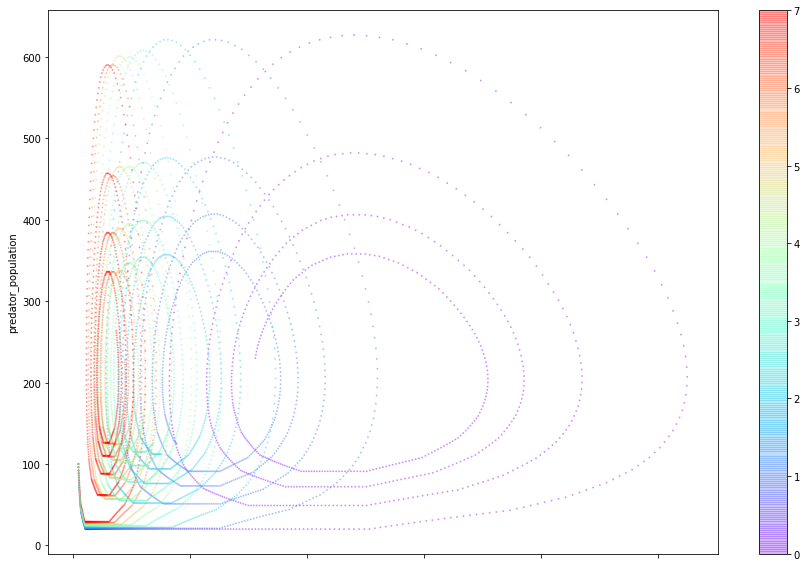

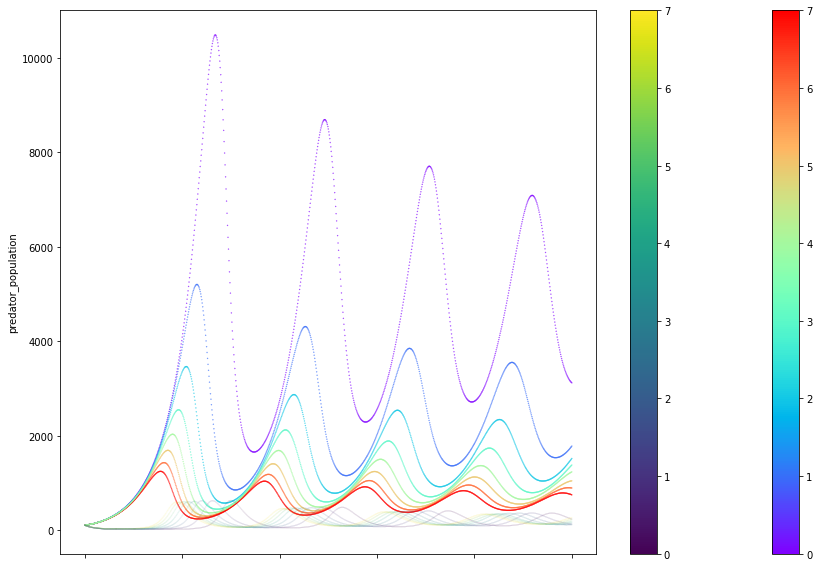

In [9]:
df.plot.scatter(
    x='prey_population',
    y='predator_population',
    color=df['subset'],
    s=1,
    colormap='rainbow' ,
    alpha=0.3
)

ax = df.plot.scatter(
    x='timestep',
    y='prey_population',
    color=df['subset'],
    s=0.1,
    colormap='rainbow' ,
)

df.plot.scatter(
    x='timestep',
    y='predator_population',
    color=df['subset'],
    s=0.001,
    colormap='viridis',
    ax=ax
);